## **Chicago 311 - Exploratory Data Analysis**
---

### **What 13.3M Service Requests can tell us about how a city really works?**


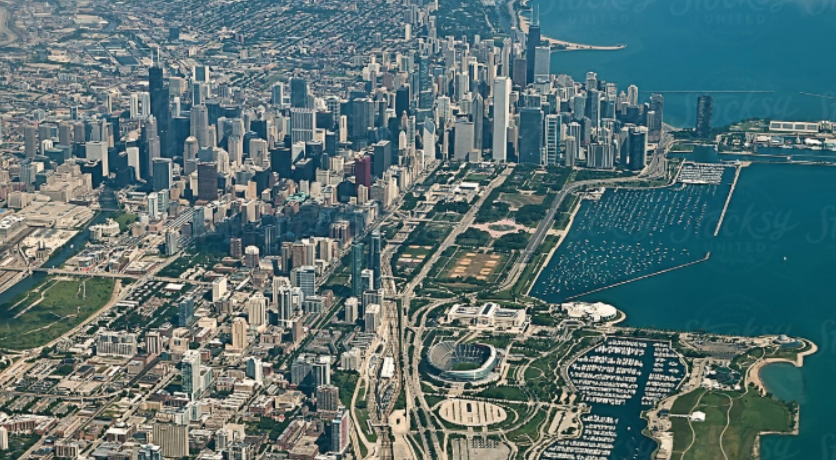


#### This notebook is an  **Exploratory Data Analysis** study of **over 6 years of [Chicago 311 Official Data](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data)** in order to uncover the main characteristics and behaviour of the city's service system through:

- **Domain Understanding**
- **Data Understanding, with**
- **Key Insights**. 
 
##### **Role in the Project:** A foundational study for guiding further analysis and modeling (e.g. segmentation, forecasting, anomaly detection, optimization). 
---

## **Domain Analysis**
---

### The **city's customer service desk**.

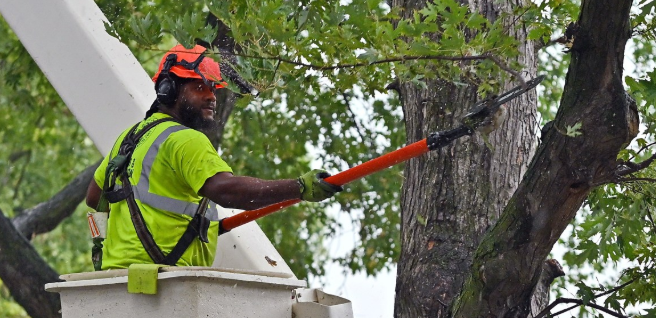



#### **[Chicago 311 - Service Requests](https://311.chicago.gov/s/?language=en_US)** is **Chicago’s official system** for **non-emergency service requests**.


**How it works:**
1. **Citizens submit requests through official channels** (Phone, web, app)
2. **Requests are routed to respective Departments** (Streets, Sanitation, Aviation)
3. **Departments handles requests** (Fix pothole, remove graffiti, trim tree.)
4. **Status updates tracked** (Open → In Progress → Completed)

**Why this data matters:**
- **13.3M records over 6 years** 
- **Spatially tagged** 
- **Time-stamped** 
- **Daily updated** -> living dataset for real-world ML

##### This detailed database provides a **real-time window** into **urban inequality**, **infrastructure decay**, and **citizen behavior**. Enabling **exceptional inteligence source** for use in **strategic planning and operational action** for **public services.**



### **Service Requests Formulary**

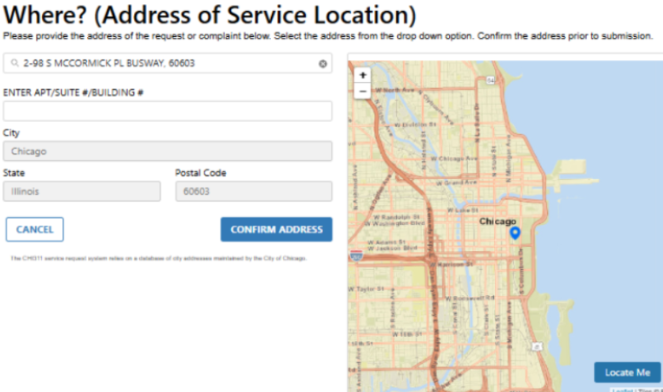



### **Service Requests examples**
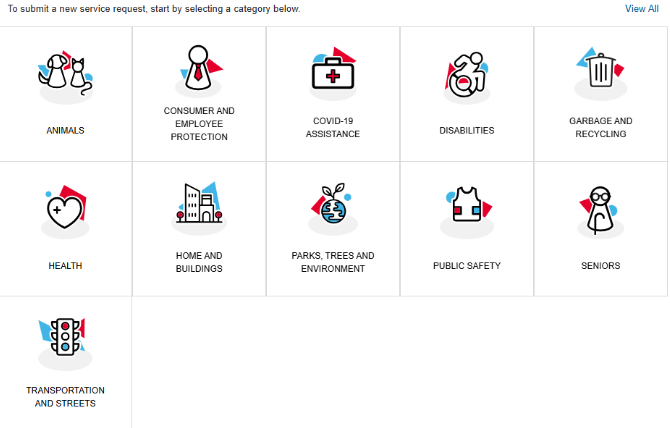

---


## **Data Understanding**
---


### **Downloading**



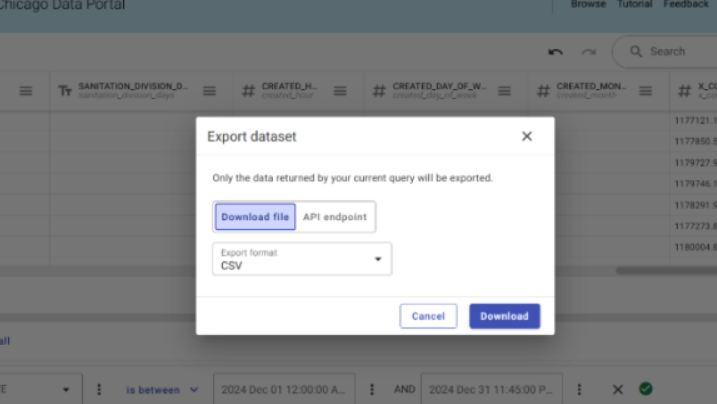


- Data is available via file **downloads** and an **API** and **yearly CSV downloads** were used to ensure full control and stability.

- Each year was downloaded separately and then stacked and converted into a **single Parquet file (~13.3M records)** (`data.parquet`), which is the source used in this notebook.

- Due to dataset size, **pandas-based EDA can be very slow or unstable**.

- **DuckDB sampling** is used to enable fast, interactive exploration while preserving representativeness.

---


### **Preparation**


In [75]:
# Importing Python libraries
import numpy as np
from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geoviews as gv
import cartopy.crs as ccrs
import datashader as ds
from holoviews.operation.datashader import datashade
from colorcet import fire


import plotly.graph_objects as go
import plotly.express as px

In [17]:
# Initializing DuckDB database
con = duckdb.connect()

**Overview**

- **39 columns** - covering: time, space, categories and status
- **Mix of types:** - timestamps, coordinates categorical labels
- **Some quality issues:** - missing values, possible duplicates and type inconsistencies

We'll fix the obvious problems first, then explore.

---


### **Preprocessing**


#### **DuckDB**

##### **SQL database** used alongside **pandas** to improve **speed and stability**.

Storing multiple large DataFrames throughout a long notebook can create memory and stability issues; DuckDB mitigates this by executing queries in a columnar engine.

Here, we use **sampling** to **inspect dominant behaviors and tendencies**, then create **SQL views** to adjust dataset characteristics, leveraging the native speed and stability of SQL queries over pandas for large datasets. 

In [ ]:
# Preview
df_sample = con.execute("""
    SELECT *
    FROM 'data/processed/data.parquet'
    USING SAMPLE 10%
""").df()

df_sample

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,CITY,CLOSED_DATE,COMMUNITY_AREA,CREATED_DATE,CREATED_DAY_OF_WEEK,CREATED_DEPARTMENT,CREATED_HOUR,CREATED_MONTH,DUPLICATE,ELECTRICAL_DISTRICT,...,STATUS,STREET_ADDRESS,STREET_DIRECTION,STREET_NAME,STREET_NUMBER,STREET_TYPE,WARD,X_COORDINATE,Y_COORDINATE,ZIP_CODE
0,None,2019-11-12 12:40:42,31,2019-11-11 15:10:16,2,311 City Services,15,11,False,None,...,Completed,1700 W 18TH PL,W,18TH,1700,PL,25,"1165296,883348","1891133,819436",60608
1,None,2019-11-12 11:44:56,67,2019-11-11 15:10:34,2,311 City Services,15,11,False,None,...,Completed,6040 S WOLCOTT AVE,S,WOLCOTT,6040,AVE,15,"1164654,89214","1864434,289113",60636
2,Chicago,2019-11-11 15:10:49,43,2019-11-11 15:10:49,2,311 City Services,15,11,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,8,"1189293,535228","1853864,411987",60612
3,Chicago,2019-11-11 15:10:50,28,2019-11-11 15:10:49,2,311 City Services,15,11,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
4,None,2019-11-21 08:12:15,6,2019-11-11 15:10:56,2,311 City Services,15,11,True,None,...,Completed,3180 N LAKE SHORE DR,N,LAKE SHORE,3180,DR,44,"1173212,469644","1921582,787248",60657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,Chicago,2020-05-12 20:02:47,28,2020-05-12 20:02:47,3,311 City Services,20,5,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
4092,Chicago,2020-05-12 20:03:11,28,2020-05-12 20:03:11,3,311 City Services,20,5,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
4093,None,2020-05-14 06:14:51,16,2020-05-12 20:03:52,3,None,20,5,False,None,...,Completed,4447 W SUNNYSIDE AVE,W,SUNNYSIDE,4447,AVE,39,"1145521,952713","1929520,93728",60630
4094,Chicago,2020-05-12 20:03:55,28,2020-05-12 20:03:54,3,311 City Services,20,5,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612


In [19]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CITY                 2529 non-null   object        
 1   CLOSED_DATE          4060 non-null   datetime64[us]
 2   COMMUNITY_AREA       4086 non-null   Int64         
 3   CREATED_DATE         4096 non-null   datetime64[us]
 4   CREATED_DAY_OF_WEEK  4096 non-null   int64         
 5   CREATED_DEPARTMENT   2907 non-null   object        
 6   CREATED_HOUR         4096 non-null   int64         
 7   CREATED_MONTH        4096 non-null   int64         
 8   DUPLICATE            4096 non-null   bool          
 9   ELECTRICAL_DISTRICT  2 non-null      object        
dtypes: Int64(1), bool(1), datetime64[us](2), int64(3), object(3)
memory usage: 296.1+ KB


In [20]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].head()

#     COLUMN               TYPE                CORRECT TYPE ?
# 0   CITY                 object              ✅        
# 1   CLOSED_DATE          datetime64[us]      ✅
# 2   COMMUNITY_AREA       Int64               ✅
# 3   CREATED_DATE         datetime64[us]      ✅
# 4   CREATED_DAY_OF_WEEK  int64               ✅
# 5   CREATED_DEPARTMENT   object              ✅
# 6   CREATED_HOUR         int64               ✅
# 7   CREATED_MONTH        int64               ✅
# 8   DUPLICATE            bool                ✅
# 9   ELECTRICAL_DISTRICT  object              ✅

,CITY,CLOSED_DATE,COMMUNITY_AREA,CREATED_DATE,CREATED_DAY_OF_WEEK,CREATED_DEPARTMENT,CREATED_HOUR,CREATED_MONTH,DUPLICATE,ELECTRICAL_DISTRICT
0,None,2019-11-12 12:40:42,31,2019-11-11 15:10:16,2,311 City Services,15,11,False,None
1,None,2019-11-12 11:44:56,67,2019-11-11 15:10:34,2,311 City Services,15,11,False,None
2,Chicago,2019-11-11 15:10:49,43,2019-11-11 15:10:49,2,311 City Services,15,11,False,None
3,Chicago,2019-11-11 15:10:50,28,2019-11-11 15:10:49,2,311 City Services,15,11,False,None
4,None,2019-11-21 08:12:15,6,2019-11-11 15:10:56,2,311 City Services,15,11,True,None


In [21]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ELECTRICITY_GRID    3509 non-null   object        
 1   LAST_MODIFIED_DATE  4096 non-null   datetime64[us]
 2   LATITUDE            4091 non-null   object        
 3   LEGACY_RECORD       4096 non-null   bool          
 4   LEGACY_SR_NUMBER    0 non-null      object        
 5   LOCATION            4091 non-null   object        
 6   LONGITUDE           4091 non-null   object        
 7   ORIGIN              4096 non-null   object        
 8   OWNER_DEPARTMENT    4096 non-null   object        
 9   PARENT_SR_NUMBER    300 non-null    object        
dtypes: bool(1), datetime64[us](1), object(8)
memory usage: 292.1+ KB


In [22]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].head()

#     COLUMN                 TYPE          CORRECT TYPE ?
# 0   ELECTRICITY_GRID       object        ✅
# 1   LAST_MODIFIED_DATE     datetime64[us]✅
# 2   LATITUDE               object        ❌ -> Int64
# 3   LEGACY_RECORD          bool          ✅
# 4   LEGACY_SR_NUMBER       object        ✅
# 5   LOCATION               object        ✅
# 6   LONGITUDE              object        ❌ -> Int64
# 7   ORIGIN                 object        ✅
# 8   OWNER_DEPARTMENT       object        ✅
# 9   PARENT_SR_NUMBER       object        ✅

,ELECTRICITY_GRID,LAST_MODIFIED_DATE,LATITUDE,LEGACY_RECORD,LEGACY_SR_NUMBER,LOCATION,LONGITUDE,ORIGIN,OWNER_DEPARTMENT,PARENT_SR_NUMBER
0,L026,2019-11-12 12:40:42,"41,85687691298",False,None,"(41.85687691297687, -87.6687558883157)","-87,66875588832",Phone Call,Streets and Sanitation,None
1,L036,2019-11-12 11:44:56,"41,78362403525",False,None,"(41.783624035253396, -87.67186679666615)","-87,67186679667",Phone Call,Streets and Sanitation,None
2,U040,2019-11-11 15:31:23,"41,75406377736",False,None,"(41.754063777362326, -87.58187238376047)","-87,58187238376",Phone Call,311 City Services,None
3,K024,2019-11-11 15:32:00,"41,87183127799",False,None,"(41.871831277993564, -87.67984621876099)","-87,67984621876",Phone Call,311 City Services,None
4,P014,2019-11-21 08:12:15,"41,94025877973",False,None,"(41.94025877972884, -87.63879672996976)","-87,63879672997",Phone Call,CDOT - Department of Transportation,SR19-02746032


In [ ]:
# Fixing types (2/4)

# New view
con.execute("""
    CREATE OR REPLACE VIEW data AS
    SELECT * REPLACE(
        REPLACE(LATITUDE,  ',', '.') :: DOUBLE AS LATITUDE,
        REPLACE(LONGITUDE, ',', '.') :: DOUBLE AS LONGITUDE
    )
    FROM 'data/processed/data.parquet';
""")

# Updating df_sample
df_sample = con.execute("""
    SELECT * FROM data USING SAMPLE 10%
""").df()

df_sample[df_sample.columns[10:20]].info()

#     COLUMN                 TYPE          CORRECT TYPE ?
# 0   ELECTRICITY_GRID       object        ✅
# 1   LAST_MODIFIED_DATE     datetime64[us]✅
# 2   LATITUDE               object        ❌ -> Int64 ✅
# 3   LEGACY_RECORD          bool          ✅
# 4   LEGACY_SR_NUMBER       object        ✅
# 5   LOCATION               object        ✅
# 6   LONGITUDE              object        ❌ -> Int64 ✅
# 7   ORIGIN                 object        ✅
# 8   OWNER_DEPARTMENT       object        ✅
# 9   PARENT_SR_NUMBER       object        ✅

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ELECTRICITY_GRID    17479 non-null  object        
 1   LAST_MODIFIED_DATE  20480 non-null  datetime64[us]
 2   LATITUDE            20474 non-null  float64       
 3   LEGACY_RECORD       20480 non-null  bool          
 4   LEGACY_SR_NUMBER    0 non-null      object        
 5   LOCATION            20474 non-null  object        
 6   LONGITUDE           20474 non-null  float64       
 7   ORIGIN              20480 non-null  object        
 8   OWNER_DEPARTMENT    20480 non-null  object        
 9   PARENT_SR_NUMBER    1153 non-null   object        
dtypes: bool(1), datetime64[us](1), float64(2), object(6)
memory usage: 1.4+ MB


In [24]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   POLICE_BEAT               20468 non-null  object
 1   POLICE_DISTRICT           20468 non-null  object
 2   POLICE_SECTOR             20468 non-null  Int64 
 3   PRECINCT                  20465 non-null  Int64 
 4   SANITATION_DIVISION_DAYS  0 non-null      object
 5   SR_NUMBER                 20480 non-null  object
 6   SR_SHORT_CODE             20480 non-null  object
 7   SR_TYPE                   20480 non-null  object
 8   STATE                     12759 non-null  object
 9   STATUS                    20480 non-null  object
dtypes: Int64(2), object(8)
memory usage: 1.6+ MB


In [25]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].head()

#     Column                        Dtype  CORRECT TYPE ?
# 0   POLICE_BEAT                    object✅
# 1   POLICE_DISTRICT                object✅
# 2   POLICE_SECTOR                  Int64 ✅
# 3   PRECINCT                       Int64 ✅
# 4   SANITATION_DIVISION_DAYS       object✅
# 5   SR_NUMBER                      object✅
# 6   SR_SHORT_CODE                  object✅
# 7   SR_TYPE                        object✅
# 8   STATE                          object✅
# 9   STATUS                         object✅

,POLICE_BEAT,POLICE_DISTRICT,POLICE_SECTOR,PRECINCT,SANITATION_DIVISION_DAYS,SR_NUMBER,SR_SHORT_CODE,SR_TYPE,STATE,STATUS
0,1931,19,3,28,None,SR19-02784969,PHF,Pothole in Street Complaint,None,Completed
1,1225,12,2,46,None,SR19-02784973,311IOC,311 INFORMATION ONLY CALL,Illinois,Completed
2,0921,09,2,21,None,SR19-02784972,SGA,Rodent Baiting/Rat Complaint,None,Completed
3,1922,19,2,16,None,SR19-02784975,SGA,Rodent Baiting/Rat Complaint,None,Completed
4,1931,19,3,24,None,SR19-02784976,311IOC,311 INFORMATION ONLY CALL,Illinois,Completed


In [26]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   STREET_ADDRESS    20474 non-null  object
 1   STREET_DIRECTION  20474 non-null  object
 2   STREET_NAME       20474 non-null  object
 3   STREET_NUMBER     20474 non-null  object
 4   STREET_TYPE       20360 non-null  object
 5   WARD              20468 non-null  Int64 
 6   X_COORDINATE      20474 non-null  object
 7   Y_COORDINATE      20474 non-null  object
 8   ZIP_CODE          19290 non-null  object
dtypes: Int64(1), object(8)
memory usage: 1.4+ MB


In [27]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]]

# 0   STREET_ADDRESS       object✅
# 1   STREET_DIRECTION     object✅
# 2   STREET_NAME          object✅
# 3   STREET_NUMBER        object✅
# 4   STREET_TYPE          object✅
# 5   WARD                 Int64 ✅
# 6   X_COORDINATE         object❌
# 7   Y_COORDINATE         object❌
# 8   ZIP_CODE             object✅

,STREET_ADDRESS,STREET_DIRECTION,STREET_NAME,STREET_NUMBER,STREET_TYPE,WARD,X_COORDINATE,Y_COORDINATE,ZIP_CODE
0,2717 N LEAVITT ST,N,LEAVITT,2717,ST,1,"1161937,464557","1918087,507589",60647
1,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
2,4052 S CAMPBELL AVE,S,CAMPBELL,4052,AVE,12,"1160304,270834","1877489,906142",60632
3,3635 N GREENVIEW AVE,N,GREENVIEW,3635,AVE,44,"1165736,514268","1924379,948774",60613
4,2111 W Lexington ST,W,Lexington,2111,ST,32,"1163248,013159","1917775,803532",60612
...,...,...,...,...,...,...,...,...,...
20475,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,7673561182","1941043,7883293368",60666
20476,5542 W HENDERSON ST,W,HENDERSON,5542,ST,30,"1138633,8577847474","1921798,076905845",None
20477,773 E OAKWOOD BLVD,E,OAKWOOD,773,BLVD,4,"1182263,6927056375","1878829,719075441",None
20478,5920 N KENNETH AVE,N,KENNETH,5920,AVE,39,"1145597,0479321","1939067,3883221268",60646


In [ ]:
# Fixing types (4/4)

# New view
con.execute("""
    CREATE OR REPLACE VIEW data_2 AS
    SELECT * REPLACE(
        regexp_replace(X_COORDINATE, ',', '.', 'g')::DOUBLE AS X_COORDINATE,
        regexp_replace(Y_COORDINATE, ',', '.', 'g')::DOUBLE AS Y_COORDINATE,
    )
    FROM data;
""")

# Updating df_sample
df_sample = con.execute("""
    SELECT * FROM data_2 USING SAMPLE 10%
""").df()
# Pandas preview
df_sample[df_sample.columns[30:40]].info()

# 0   STREET_ADDRESS       object✅
# 1   STREET_DIRECTION     object✅
# 2   STREET_NAME          object✅
# 3   STREET_NUMBER        object✅
# 4   STREET_TYPE          object✅
# 5   WARD                 Int64 ✅
# 6   X_COORDINATE         object❌ -> Int64 ✅
# 7   Y_COORDINATE         object❌ -> Int64 ✅
# 8   ZIP_CODE             object✅

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14336 entries, 0 to 14335
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STREET_ADDRESS    14307 non-null  object 
 1   STREET_DIRECTION  14306 non-null  object 
 2   STREET_NAME       14307 non-null  object 
 3   STREET_NUMBER     14307 non-null  object 
 4   STREET_TYPE       14202 non-null  object 
 5   WARD              14298 non-null  Int64  
 6   X_COORDINATE      14307 non-null  float64
 7   Y_COORDINATE      14307 non-null  float64
 8   ZIP_CODE          13819 non-null  object 
dtypes: Int64(1), float64(2), object(6)
memory usage: 1022.1+ KB


In [29]:
# duplicates

# total rows vs unique rows
df_count = con.execute("""
    SELECT
        COUNT(*) AS rows,
        (
            SELECT COUNT(*)
            FROM (SELECT DISTINCT * FROM data_2)
        ) AS unique_rows
    FROM data_2;
""").df()

df_count

# Each full row represents a single Service Request, therefore, the only way to a full row be present, is 
# a overlap while joining multiple years during the dataset creation

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,rows,unique_rows
0,15241367,13301203


In [30]:
# Excluding ducplicates
con.execute("""
    CREATE OR REPLACE VIEW data_3 AS
    SELECT DISTINCT * 
    FROM data_2;
""")

# total rows vs unique rows
df_count = con.execute("""
    SELECT
        COUNT(*) AS rows,
        (
            SELECT COUNT(*)
            FROM (SELECT DISTINCT * FROM data_3)
        ) AS unique_rows
    FROM data_3;
""").df()

df_count

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,rows,unique_rows
0,13301203,13301203


**Overview**

**Fixed:**
- ✅ Coordinate types (lat/lon were strings with commas)
- ✅ Removed duplicate rows

---

### **🔬 Exploratory Data Analysis**

Now we investigate **five key dimensions**:

- **Data Structure** 
- **Operational**
- **Time Series**
- **Geographical**
- **Relationships**  

#### **Data Structure** 

##### **Missingness**

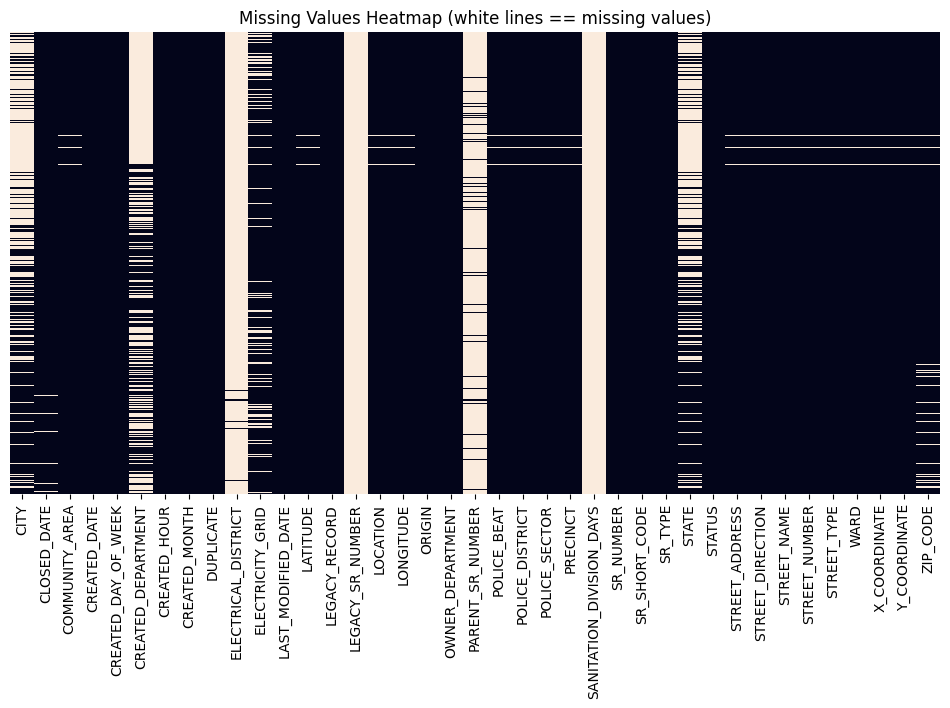

LEGACY_SR_NUMBER            100.00
SANITATION_DIVISION_DAYS    100.00
ELECTRICAL_DISTRICT          98.98
PARENT_SR_NUMBER             93.41
CREATED_DEPARTMENT           55.98
CITY                         46.86
STATE                        46.86
ELECTRICITY_GRID             15.90
ZIP_CODE                      3.61
CLOSED_DATE                   1.07
STREET_TYPE                   0.93
PRECINCT                      0.28
WARD                          0.27
POLICE_DISTRICT               0.26
COMMUNITY_AREA                0.26
POLICE_SECTOR                 0.26
POLICE_BEAT                   0.26
STREET_DIRECTION              0.21
X_COORDINATE                  0.20
STREET_NUMBER                 0.20
STREET_NAME                   0.20
LONGITUDE                     0.20
LATITUDE                      0.20
LOCATION                      0.20
STREET_ADDRESS                0.20
dtype: float64

In [31]:
# Ploting missiness percentage with sampling

# Sorting
df_sample = df_sample.sort_values("CREATED_DATE")

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(df_sample.isna(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap (white lines == missing values)')
plt.show()

# white lines -> missing values

# Missingess %
(df_sample.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)

# High missingess columns:

# Unusable! (>80%)
# LEGACY_SR_NUMBER
# SANITATION_DIVISION_DAYS
# PARENT_SR_NUMBER
# ELECTRICAL_DISTRICT

# "Usable" if necessary
# CREATED_DEPARTMENT
# STATE
# CITY
# ELETRICITY_GRID
# ZIP_CODE

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

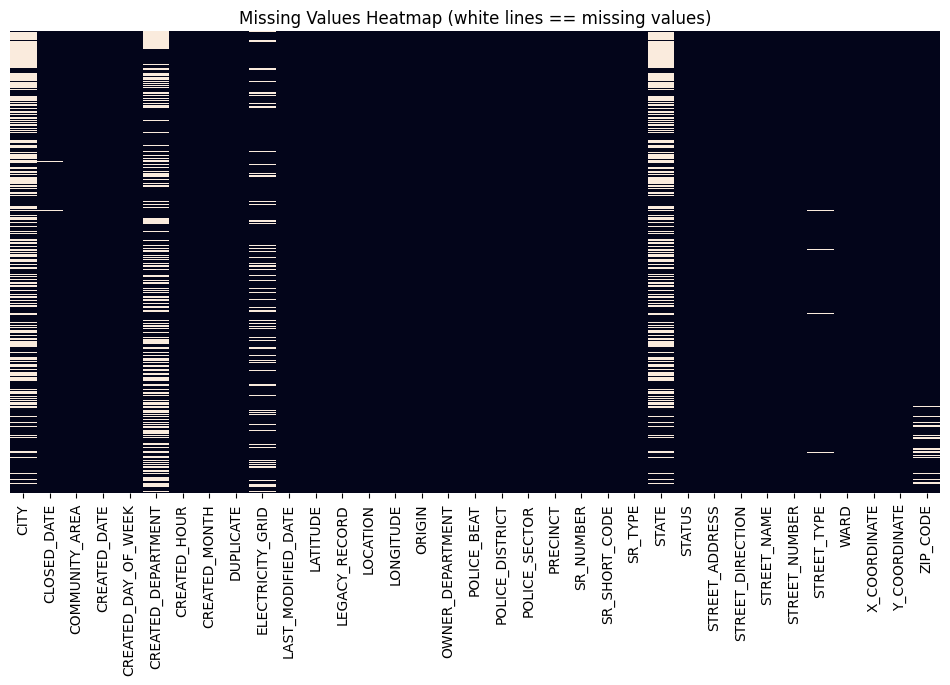

CITY                  44.54
STATE                 44.54
CREATED_DEPARTMENT    39.43
ELECTRICITY_GRID      15.00
ZIP_CODE               2.53
CLOSED_DATE            1.18
STREET_TYPE            0.84
PRECINCT               0.17
POLICE_SECTOR          0.15
POLICE_DISTRICT        0.15
POLICE_BEAT            0.15
COMMUNITY_AREA         0.14
WARD                   0.14
STREET_DIRECTION       0.12
STREET_ADDRESS         0.12
LOCATION               0.12
LATITUDE               0.12
LONGITUDE              0.12
STREET_NUMBER          0.12
X_COORDINATE           0.12
STREET_NAME            0.12
Y_COORDINATE           0.12
ORIGIN                 0.00
CREATED_HOUR           0.00
CREATED_MONTH          0.00
dtype: float64

In [ ]:
# Excluding high missingness columns

# New view
con.execute("""
    CREATE OR REPLACE VIEW data_4 AS
    SELECT * EXCLUDE(
            LEGACY_SR_NUMBER,
            SANITATION_DIVISION_DAYS, 
            PARENT_SR_NUMBER, 
            ELECTRICAL_DISTRICT)
    FROM data_3;
""")

# Updating df_sample
df_sample = con.execute("""
    SELECT * FROM data_4 USING SAMPLE 10%
""").df()

# New missiness percentage with sampling

# Sorting
df_sample = df_sample.sort_values("CREATED_DATE")

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(df_sample.isna(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap (white lines == missing values)')
plt.show()

# white lines -> missing values

# Missingess %
(df_sample.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)

In [33]:
# Leading/lrailing whitespaces

# VARCHAR column of `data_4`
columns = con.execute("""
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'data_4'
      AND data_type LIKE '%VARCHAR%'
""").fetchall()

# Dynamic WHERE clause
conditions = " OR ".join(
    [
        f'"{col[0]}" IS NOT NULL AND "{col[0]}" != TRIM("{col[0]}")' # column is not null + original and trimmed are different
        for col in columns
    ]
)

# Execute query with dynamic WHERE clause
result = con.execute(f"""
    SELECT EXISTS (
        SELECT 1
        FROM data_4
        WHERE {conditions}
    );
""").fetchone()


# Output
#    True  - at least one whitespace issue exists
#    False - no whitespace detected

result # False

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(False,)

**Overview**

**White horizontal lines = missing values**

- **>80% missing** - drop 
- **=<40% missing** - keep (might be analytically interesting later)
- **No whitespaces found in text columns** — strong consistency across categorical fields.
---

#### **Columns**

In [34]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16384 entries, 9079 to 9063
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CITY                 9086 non-null   object        
 1   CLOSED_DATE          16191 non-null  datetime64[us]
 2   COMMUNITY_AREA       16361 non-null  Int64         
 3   CREATED_DATE         16384 non-null  datetime64[us]
 4   CREATED_DAY_OF_WEEK  16384 non-null  int64         
 5   CREATED_DEPARTMENT   9924 non-null   object        
 6   CREATED_HOUR         16384 non-null  int64         
 7   CREATED_MONTH        16384 non-null  int64         
 8   DUPLICATE            16384 non-null  bool          
 9   ELECTRICITY_GRID     13926 non-null  object        
 10  LAST_MODIFIED_DATE   16384 non-null  datetime64[us]
 11  LATITUDE             16365 non-null  float64       
 12  LEGACY_RECORD        16384 non-null  bool          
 13  LOCATION             16365 non-nul

#### **Dataset Columns**

The dataset is left with **35 columns**.

The analysis will cover **key columns** represent most of the relevant data and the **secondary columns** will be put aside for now, due to high redundancy information

### **Key Columns**

**Operational**
- SR_TYPE  
- CREATED_DEPARTMENT  
- OWNER_DEPARTMENT  
- STATUS  
- ORIGIN 

**Time Series**
- CREATED_DATE  
- LAST_MODIFIED_DATE  

**Geographical**
- LATITUDE  
- LONGITUDE  

### **Secondary Columns**

- CITY  
- CLOSED_DATE  
- COMMUNITY_AREA  
- CREATED_DAY_OF_WEEK  
- CREATED_HOUR  
- CREATED_MONTH  
- DUPLICATE  
- ELECTRICITY_GRID  
- LEGACY_RECORD  
- LOCATION  
- POLICE_BEAT  
- POLICE_DISTRICT  
- POLICE_SECTOR  
- PRECINCT  
- SR_NUMBER  
- SR_SHORT_CODE  
- STATE  
- STREET_ADDRESS  
- STREET_DIRECTION  
- STREET_NAME  
- STREET_NUMBER  
- STREET_TYPE  
- WARD  
- X_COORDINATE  
- Y_COORDINATE  
- ZIP_CODE  

---

#### **Operational**

##### **SR_TYPE**


In [35]:
# SR_TYPE top 10
(df_sample['SR_TYPE']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(10)

SR_TYPE
311 INFORMATION ONLY CALL                       35.15
Aircraft Noise Complaint                        14.81
Graffiti Removal Request                         4.23
Street Light Out Complaint                       3.28
Rodent Baiting/Rat Complaint                     2.94
Garbage Cart Maintenance                         2.92
Pothole in Street Complaint                      2.78
Tree Trim Request (NO LONGER BEING ACCEPTED)     2.64
Weed Removal Request                             2.31
Abandoned Vehicle Complaint                      1.96
Name: proportion, dtype: float64

**Overview**

- **"Information Only Call" dominates** — Many requests appear to be inquiries rather than actionable issues or maybe possibly functioning as a generic category.  
- **"Aircraft Noise Complaint" is the most common complaint** — The region hosts multiple major airports; further geographic analysis may clarify their spatial impact.  
- **General infrastructure complaints** — Categories related to buildings, roads, trees, water, and sanitation represent most of public service operational workload.

In [37]:
# Rare yet high aging
rare_and_aging = (con.execute("""
SELECT
    SR_TYPE,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct,
    COUNT(*) AS count
FROM data_4
WHERE CREATED_DATE IS NOT NULL
GROUP BY SR_TYPE
ORDER BY avg_days_open DESC, pct, count DESC
LIMIT 10;
""")
    .df()
)

rare_and_aging

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,SR_TYPE,avg_days_open,pct,count
0,Sidewalk Inspection Request,702.01,0.48,63959
1,Shared Cost Sidewalk Program Request,470.58,0.12,15649
2,Commercial Fire Safety Inspection Request,442.29,0.02,2164
3,Street Light Pole Door Missing Complaint,434.10,0.05,6366
4,Tree Planting Request,344.81,0.65,86425
5,Bicycle Request/Complaint,317.90,0.04,5213
6,Protected Bike Lane - Debris Removal,308.23,0.01,1647
7,Licensed Pharmaceutical Representative Complaint,286.12,0.00,52
8,Street Light On During Day Complaint,261.68,0.07,9689
9,Water Lead Test Visit Request,218.75,0.12,16288


**📝 Overview**

**Over 2 years open:**
- *Sidewalk **Inspection** Request*

**Over 1 year open:**
- *Shared Cost Sidewalk Program Request*	
- *Commercial Fire Safety Inspection Request*	
- *Street Light Pole Door Missing Complaint*	

**Almost an year open:**
- *Tree Planting Request*	
- *Bicycle Request/Complaint*	
- *Protected Bike Lane - Debris Removal*	

Several **inspection and infrastructure-related** requests stay open much longer, what could indicate **possible backlog or administrative hurdles** rather than normal delays.

---

##### **CREATED_DEPARTMENT**


In [38]:
# CREATED_DEPARTMENT top 10
(df_sample['CREATED_DEPARTMENT']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(10)
# 311 City Services dominates the distribution

CREATED_DEPARTMENT
311 City Services                                  86.93
Alderman                                            6.09
Streets and Sanitation                              3.37
CDOT - Department of Transportation                 3.02
DWM - Department of Water Management                0.24
Animal Care and Control                             0.09
BACP - Business Affairs and Consumer Protection     0.08
DOB - Buildings                                     0.08
Health                                              0.05
Police                                              0.03
Name: proportion, dtype: float64

##### **OWNER_DEPARTMENT**


In [39]:
# OWNER_DEPARTMENT top 10
(df_sample['OWNER_DEPARTMENT']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(10)

# 311 City Services + Aviation - Still dominant
# Streets and Sanitation + Administrative Departments - High Frequency

OWNER_DEPARTMENT
311 City Services                                  35.15
Streets and Sanitation                             27.91
Aviation                                           14.81
CDOT - Department of Transportation                11.64
DWM - Department of Water Management                4.74
DOB - Buildings                                     2.67
Animal Care and Control                             1.93
BACP - Business Affairs and Consumer Protection     0.71
Health                                              0.18
City Clerk's Office                                 0.10
Name: proportion, dtype: float64

**Overview**

- **311 City Services + Alderman = ~90%** - Most requests seems to funnel through these departments before routing
- **Bureaucracy and Infrastructure** -  Inspections, permits, complaints and infrastructure-related requests represent the rest of services


##### **STATUS**


In [40]:
# STATUS top 10
(df_sample['STATUS']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(10)

# >90% of requests are marked as "Completed".
# closure may be driven by automatic rules or operational workflows,
# which could bias SLA/time-to-close modeling and class imbalance.

STATUS
Completed    97.54
Canceled      1.28
Open          1.18
Name: proportion, dtype: float64

In [41]:
# Rare yet high aging
rare_and_aging = (con.execute("""
SELECT
    SR_TYPE,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct,
    COUNT(*) AS count,
    COUNT(*) FILTER (WHERE CLOSED_DATE IS NULL) AS null_closed
FROM data_4
WHERE CREATED_DATE IS NOT NULL
GROUP BY SR_TYPE
ORDER BY avg_days_open DESC, pct, count DESC
LIMIT 10;
""")
    .df()
)

rare_and_aging

# Stray Animal: unresolved/unsuccessful capture ?
# Water and Tree related categories dominate operational workload even outside "Completed".

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,SR_TYPE,avg_days_open,pct,count,null_closed
0,Sidewalk Inspection Request,702.01,0.48,63959,20174
1,Shared Cost Sidewalk Program Request,470.58,0.12,15649,6921
2,Commercial Fire Safety Inspection Request,442.29,0.02,2164,7
3,Street Light Pole Door Missing Complaint,434.10,0.05,6366,767
4,Tree Planting Request,344.81,0.65,86425,22775
5,Bicycle Request/Complaint,317.90,0.04,5213,1003
6,Protected Bike Lane - Debris Removal,308.23,0.01,1647,367
7,Licensed Pharmaceutical Representative Complaint,286.12,0.00,52,0
8,Street Light On During Day Complaint,261.68,0.07,9689,26
9,Water Lead Test Visit Request,218.75,0.12,16288,3100


**Overview**

- **Nearly 100% Completed** - Services request could be auto-closed (Completed <> Solved)?
- **Not Completed:** The few that don't auto-complete reveal some of the the system's **real challenges**.
- **Stray animals** - Only closes if the animal is captured?
- **Water/Tree issues remain dominant** - High backlog?


##### **ORIGIN**


In [42]:
# ORIGIN top 10
(df_sample['ORIGIN']
    .value_counts(normalize=True)
    .sort_values(ascending=False) * 100
    ).round(decimals=2).head(10)

ORIGIN
Phone Call                  59.87
Internet                    25.73
Mobile Device                7.06
Alderman's Office            3.23
Mass Entry                   3.10
Generated In House           0.18
Salesforce Mobile App        0.17
DWM                          0.16
spot-open311-SeeClickFix     0.15
SPOTCSR                      0.12
Name: proportion, dtype: float64

In [43]:
# Rare yet high aging
rare_and_aging = con.execute("""
  SELECT
      ORIGIN,
      ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct,
      ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open
                      
  FROM data_4
                        
  WHERE CREATED_DATE IS NOT NULL
                             
  GROUP BY ORIGIN
  ORDER BY pct DESC, avg_days_open DESC;
""").df()

rare_and_aging

# Legacy methods are very slow yet very rare
# E-mail, though modern, is slow and rare as mail
# Walking-in beats a State Representative by almost a week!
# A phone call is probably the most reliable way to register a complain!

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,ORIGIN,pct,avg_days_open
0,Phone Call,57.41,16.09
1,Internet,26.94,22.30
2,Mobile Device,7.46,39.42
3,Mass Entry,3.76,0.01
4,Alderman's Office,3.24,60.04
5,Salesforce Mobile App,0.24,31.05
6,DWM,0.23,57.60
7,SPOTCSR,0.22,12.89
8,Generated In House,0.18,62.98
9,spot-open311-SeeClickFix,0.08,82.09


**Overview**
- **Phone Call leads** — resolution time is reasonable.
- **Internet and Mobile aren’t faster** — they can take longer.
- **Alderman’s Office requests can take much longer** 

---

#### **Time Series**


In [ ]:
# All time 
df_month = con.execute("""
    SELECT
        strftime(CREATED_DATE, '%m/%y') AS month,
        COUNT(*) AS n_requests
    FROM data_4
    GROUP BY month
    ORDER BY MIN(CREATED_DATE)
""").df()

df_month

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,month,n_requests
0,07/18,4228
1,08/18,4229
2,09/18,4746
3,10/18,7888
4,11/18,5513
...,...,...
87,10/25,174490
88,11/25,155418
89,12/25,153962
90,01/26,154830


In [45]:
year_change_marks = (
    df_month["month"]
    .astype(str)
    .loc[lambda x: x.str.startswith("01/")]
)

year_change_marks

6     01/19
18    01/20
30    01/21
42    01/22
54    01/23
66    01/24
78    01/25
90    01/26
Name: month, dtype: object

In [46]:

fig = px.line(
    df_month,
    x="month",
    y="n_requests",
    title="Monthly Total 311 Service Requests"
)

for m in year_change_marks:
    fig.add_vline(x=m, line_width=2, line_color="red", opacity=0.9)

fig.update_layout(
    xaxis_title="Month (mm/yy)",
    yaxis_title="Number of Requests",
    xaxis_tickfont_size=8,
    height=400,
    template="plotly_dark"
)

fig.show()

In [47]:
# Weekly aggregation
df_dow = con.execute("""
    SELECT
        CREATED_DAY_OF_WEEK AS day_of_week,
        COUNT(*) AS n_requests
    FROM data_4
    WHERE CREATED_DAY_OF_WEEK IS NOT NULL
    GROUP BY 1
    ORDER BY 1
""").df()

# Plot with Plotly
fig = px.line(
    df_dow,
    x="day_of_week",
    y="n_requests",
    markers=True,
    title="Requests by Day of Week",
    template="plotly_dark"
)

fig.update_layout(
    xaxis_tickmode="array",
    xaxis_tickvals=[1,2,3,4,5,6,7],
    xaxis_ticktext=["Sun","Mon","Tue","Wed","Thu","Fri","Sat"],
    xaxis_title="Day of Week",
    yaxis_title="Count"
)

fig.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [48]:
# Requests by hour of the day (Plotly)

df_hour = con.execute("""
    SELECT
        CREATED_HOUR AS hour,
        COUNT(*) AS n_requests
    FROM data_4
    WHERE CREATED_HOUR IS NOT NULL
    GROUP BY hour
    ORDER BY hour
""").df()

fig = px.line(
    df_hour,
    x="hour",
    y="n_requests",
    markers=True,
    title="Requests by Hour of the Day",
    template="plotly_dark"
)

fig.update_layout(
    xaxis_tickmode="array",
    xaxis_tickvals=list(range(0, 24)),
    xaxis_title="Hour of the Day",
    yaxis_title="Count"
)

fig.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

**Overview**

- **Annual seasonality:** recurring mid-year peaks and winter slowdowns  
- **Weekly pattern:** higher volumes on weekdays compared to weekends  
- **Daily pattern:** concentration during business hours  

---

#### **🗺️ Geographic Patterns**


In [49]:
# % valid coordinates
stats = con.execute("""
    SELECT
        COUNT(*) AS n_total,
        COUNT(*) FILTER (
            WHERE latitude BETWEEN -90 AND 90
            AND longitude BETWEEN -180 AND 180
        ) AS n_valid
    FROM data_4
""").df()
stats["pct_valid"] = stats["n_valid"] / stats["n_total"]
stats["pct_valid"]

# almost 100%

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

0    0.998965
Name: pct_valid, dtype: float64

**Overview**

**✅ Nearly 100% valid coordinates** → Excellent spatial data quality

This enables robust geographic analysis.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
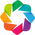

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'2b076796-90bb-4eec-8cf7-ce234f4dda0b': {'version…

In [80]:
# Service Requests Density
gv.extension("bokeh")
df = con.execute("""
    SELECT latitude AS lat, longitude AS lon
    FROM data_4
    WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

locations = gv.Points(df, ["lon", "lat"])
points = datashade(locations, width=2400, height=2400,  cmap=fire, cnorm='eq_hist')
(gv.tile_sources.CartoDark * points).opts(width=800, height=800)


# All time city overview

**Overview**

- Concentration spikes in the northen half of the city, especially near downtown and visible critic avenues
- Southern half have clearly less concentration spikes, especially near the city limits

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
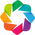

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'e71870bf-3620-4001-93b1-e53edad48c80': {'version…

In [95]:
# Service Requests "Open Days" Distribution

gv.extension("bokeh")

df = con.execute("""
    SELECT
        latitude  AS lat,
        longitude AS lon,
        DATE_DIFF('day', CREATED_DATE, CLOSED_DATE) AS open_days
    FROM data_4
    WHERE latitude IS NOT NULL
    AND longitude IS NOT NULL
    AND CLOSED_DATE IS NOT NULL
""").df()

locations = gv.Points(df, ["lon", "lat"], vdims=["open_days"])

points = datashade(locations, aggregator=ds.mean("open_days"), width=2400,height=2400,cmap=fire, cnorm="eq_hist")
(gv.tile_sources.CartoDark * points).opts(width=800, height=800)

**Overview**

- Plotting the same points, but using the mean of days open as the shader criteria, we get **almost the oposite** of the last plot:
- Service Requests open time spikes across the entire map near the city limits


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
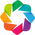

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'966383b1-1410-4321-9aae-093e5aefdeb6': {'version…

In [ ]:
# Service Requests aircraft noise complaint
gv.extension("bokeh")

df = con.execute("""
    SELECT
        latitude  AS lat,
        longitude AS lon,
        COUNT(*)  AS noise_complaint
    FROM data_4
    WHERE latitude IS NOT NULL
      AND longitude IS NOT NULL
      AND SR_TYPE ILIKE '%aircraft%'
    GROUP BY 1, 2
""").df()

locations = gv.Points(df, ["lon", "lat"], vdims=["noise_complaint"])
points = datashade(locations, aggregator=ds.count(), width=2400,height=2400,cmap=fire, cnorm="eq_hist")
(gv.tile_sources.CartoDark * points).opts(width=800, height=800)

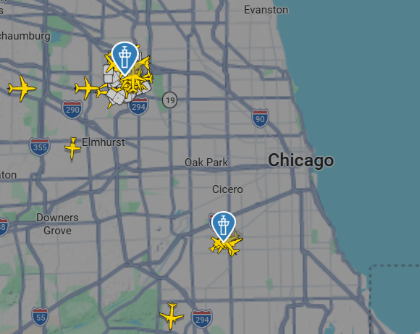
- Some can be related to the o'hailey airport and some to the chicago international airport

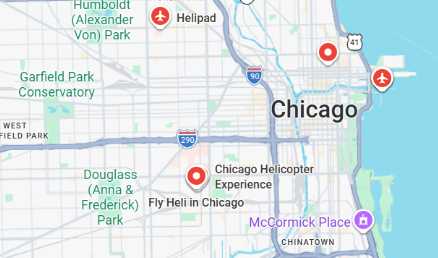
- The ones near downtown have no airports, but the complaints could be related to planes on the appróach to the airports or maybe to some heliports close to the reports near the middle

**Overview**
parei aqui
**Critical question:** Is low density in the South due to fewer problems, or **fewer reports**?

**This pattern mirrors Chicago's historical segregation and inequality.**



**Overview**

**The darker areas (longer resolution times) are in:**
- **South Side** (especially Far South)
- **Far Northwest** (edges of the city)

**The fastest resolutions are in:**
- **Downtown/Loop**
- **Near North Side**

**Why this gap?**
- **Resource allocation** - More staff/equipment in central areas?
- **Political power** - Wealthier areas get faster service?
- **Request complexity** - Peripheral areas have harder-to-fix infrastructure?

**This is evidence of systemic inequality** in city service delivery.

**For ML:** Geographic features (ward, distance from downtown) will be strong predictors of resolution time.



#### **🔗 Hidden Relationships**

Individual analyses are informative. But **cross-tabulations** expose:
- Routing inefficiencies
- Seasonal quirks by request type
- Predictability of outcomes



In [83]:
# SR_TYPE × STATUS — heatmap
df_SR_status = con.execute("""
    SELECT
        SR_TYPE,
        STATUS,
        COUNT(*) AS n,
        COUNT(*) * 1.0 / SUM(COUNT(*)) OVER (PARTITION BY SR_TYPE) AS pct
    FROM data_6
    GROUP BY SR_TYPE, STATUS
    ORDER BY SR_TYPE, pct DESC
""").df()

df_SR_status["pct"] = df_SR_status["pct"].round(2)

# order by % Completed (ascending)
order = (
    df_SR_status[df_SR_status["STATUS"] == "Completed"]
    .sort_values("pct", ascending=False)["SR_TYPE"]
)

piv = (
    df_SR_status
    .pivot(index="SR_TYPE", columns="STATUS", values="pct")
    .loc[order]
    .fillna(0)
)

plt.figure(figsize=(9, 7))
sns.heatmap(piv, cmap="viridis", annot=False, fmt=".2f", cbar_kws={"label": "Proportion"})
plt.xlabel("Status")
plt.ylabel("Service Request Type")
plt.title("SR_TYPE × STATUS (Proportion)")
plt.tight_layout()
plt.show()

# many SR_TYPES are near-deterministic in outcome ('Completed')
# this high predictability implies limited opportunities for modeling SR_STATUS.
# is there a possibility to infer if and wich types could have automatic clousure?

CatalogException: Catalog Error: Table with name data_6 does not exist!
Did you mean "data"?

LINE 7:     FROM data_6
                 ^

**Overview**

**Almost every request type shows >85% "Completed"**

**This suggests:**
- Many requests are **administratively closed** without field verification
- "Completed" may mean "ticket closed" not "problem solved"
- System is optimized for **closure speed**, not **resolution quality**

**Why this matters:**
- Limited opportunity for ML to predict STATUS (too deterministic)
- We should focus on **time-to-close** rather than final status
- True quality metrics (citizen satisfaction) are missing from this data

**Policy implication:** Chicago may be gaming its own metrics.


In [ ]:
# CREATED × OWNER mislocation heatmap
df_hm = con.execute("""
    WITH agg AS (
        SELECT
            OWNER_DEPARTMENT,
            CREATED_DEPARTMENT,
            COUNT(*) AS n
        FROM data_6
        WHERE OWNER_DEPARTMENT IS NOT NULL AND CREATED_DEPARTMENT IS NOT NULL
        GROUP BY 1, 2
    ),
    tot AS (
        SELECT OWNER_DEPARTMENT, SUM(n) AS total_n
        FROM agg
        GROUP BY 1
    ),
    mis AS (
        SELECT
            a.OWNER_DEPARTMENT,
            a.CREATED_DEPARTMENT,
            (a.n * 100.0) / t.total_n AS pct
        FROM agg a
        JOIN tot t
        ON a.OWNER_DEPARTMENT = t.OWNER_DEPARTMENT
    ),
    mis_rate AS (
        SELECT
            OWNER_DEPARTMENT,
            SUM(CASE WHEN CREATED_DEPARTMENT <> OWNER_DEPARTMENT THEN pct ELSE 0 END) AS mis_pct
        FROM mis
        GROUP BY 1
    )
    SELECT
        m.OWNER_DEPARTMENT,
        m.CREATED_DEPARTMENT,
        m.pct
    FROM mis m
    JOIN mis_rate r
    ON m.OWNER_DEPARTMENT = r.OWNER_DEPARTMENT
    ORDER BY r.mis_pct DESC
""").df()

piv = (
    df_hm
    .pivot(
        index="CREATED_DEPARTMENT",   # Y: where it was created
        columns="OWNER_DEPARTMENT",   # X: correct department
        values="pct"
    )
    .fillna(0)
    .round(1)
)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(piv, cmap="viridis", annot=False, cbar_kws={"label": "% of requests (row-normalized)"})
ax.set_xlabel("OWNER_DEPARTMENT (correct)")
ax.set_ylabel("CREATED_DEPARTMENT (where it was created)")
ax.set_title("CREATED × OWNER Mislocation Heatmap")
ax.invert_yaxis()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# 311 and Alderman receives most of the complaints and direct them to the OWNER department


**Overview**

**Almost every request type shows >85% "Completed"**

**This suggests:**
- Many requests are **administratively closed** without field verification
- "Completed" may mean "ticket closed" not "problem solved"
- System is optimized for **closure speed**, not **resolution quality**

**Why this matters:**
- Limited opportunity for ML to predict STATUS (too deterministic)
- We should focus on **time-to-close** rather than final status
- True quality metrics (citizen satisfaction) are missing from this data

**Policy implication:** Chicago may be gaming its own metrics.



In [ ]:
# SR_TYPE × MONTH — heatmap top 20
df = con.execute("""
    WITH top_sr AS (
        SELECT SR_TYPE
        FROM data_6
        GROUP BY SR_TYPE
        ORDER BY COUNT(*) DESC
        LIMIT 20
    )
    SELECT
        d.SR_TYPE,
        STRFTIME(d.CREATED_DATE, '%Y-%m') AS month,
        COUNT(*) AS n
    FROM data_6 d
    JOIN top_sr t
    ON d.SR_TYPE = t.SR_TYPE
    GROUP BY 1, 2
""").df()

# normalize per SR_TYPE (row sums to 1)
piv = (
    df
    .pivot(index="SR_TYPE", columns="month", values="n")
    .fillna(0)
)
piv = piv.div(piv.sum(axis=1), axis=0)

plt.figure(figsize=(16, max(6, 0.3 * len(piv))))
ax = sns.heatmap(piv, cmap="viridis", annot=False)
ax.set_xlabel("Month")
ax.set_ylabel("SR_TYPE")
ax.set_title("SR_TYPE × MONTH (Percentage per SR_TYPE)")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
plt.show()

# Most SR types peak mid-year, consistent with the time-series results
# 'Pothole in the Street' shows an inverted seasonal pattern
# Several SR types exhibit no clear seasonality

**Overview**

**Strong diagonal = requests correctly routed**
**Off-diagonal = misrouting**

**Key finding:** "311 City Services" and "Office of the Mayor" receive requests for **every department**
- *Insight:* They act as **central switchboards**, not service providers

**Why misrouting happens:**
- Citizens don't know which department handles what
- Intake operators misclassify issues
- Some issues require multiple departments (who becomes "owner"?)

**Implication for ML:** We could build a **smart router** to predict correct department from request text.



In [ ]:
# season boxplot

**Overview**

**Most types peak mid-year** (consistent with volume analysis)

**But "Pothole in Street" has inverted seasonality!**
- *Why?* **Winter freeze-thaw cycles destroy pavement** → potholes appear in spring
- Requests lag behind the actual damage

**Other observations:**
- Aircraft noise shows little seasonality (consistent year-round annoyance)
- Tree-related requests peak in summer (growth season)

**For ML:** Request type + month interactions will be powerful features.



## **Key Insights**
---


After analyzing 7.6M service requests, here's what the data reveals:



#### **1. 🏙️ Chicago Has Strong Urban Rhythms**

**Temporal patterns:**
- **40% surge in summer** (May-Aug) vs. winter (Nov-Feb)
- **75% of requests on weekdays**, peaking 9 AM - 5 PM
- System operates on **business hours**, even though problems happen 24/7

**What this means:**
- Infrastructure stress is **seasonal and predictable**
- Staffing should flex with demand curves
- After-hours issues may go unreported



#### **2. 🗺️ Geography Reveals Inequality**

**Spatial patterns:**
- **North Side density >> South Side** (wealth correlates with reporting)
- **Periphery has 2x slower resolution** than downtown
- Major roads show as "hotlines" of complaints

**What this means:**
- Service delivery is **geographically unequal**
- Resource allocation favors central/wealthy areas
- Data mirrors Chicago's historical segregation



#### **3. 🏛️ The System Has Operational Quirks**

**Completion patterns:**
- **90% of requests marked "Completed"** (suspiciously high)
- Likely **auto-closure** or administrative shortcuts
- "Completed" ≠ "problem actually solved"

**Routing issues:**
- **311 City Services handles 70% of intake** (centralized bottleneck)
- Frequent **misrouting** between departments
- Resolution speed depends on **how you report** (phone > email > mail)

**What this means:**
- Metrics may be gamed (optimizing closure rate over quality)
- Smart routing could reduce delays
- Access inequality (digital divide affects service speed)



#### **4. 📊 Request Types Have "Personalities"**

**Volume leaders:**
- Aircraft noise, tree trims, potholes dominate
- Long tail of rare but slow issues (tree removals take 180+ days)

**Seasonal quirks:**
- **Potholes have inverted seasonality** (winter damage → spring reports)
- Most types peak in summer (outdoor visibility effect)

**What this means:**
- Resource allocation is skewed to high-volume categories
- Rare-but-slow issues get neglected (ML should weight by impact, not frequency)



#### **5. 🤖 Strong Signal for Machine Learning**

**Predictive features identified:**
- ✅ **Season/month** (clear patterns)
- ✅ **Geography** (ward, distance from downtown)
- ✅ **Request type** (different SLA profiles)
- ✅ **Day of week + hour** (business hours effect)
- ✅ **Department routing** (bottleneck indicator)

**Challenges for ML:**
- ⚠️ **Class imbalance** (90% "Completed")
- ⚠️ **Data quality** (auto-closure may corrupt labels)
- ⚠️ **Rare events** (long tail of infrequent types)



#### **6. 🔍 Data Quality Flags**

**Issues discovered:**
- 60%+ missing in legacy columns (safely dropped)
- Coordinate types were malformed (fixed)
- No true quality metrics (citizen satisfaction missing)

**What we can't answer:**
- ❌ Are citizens satisfied with resolutions?
- ❌ What's the true cost per request type?
- ❌ Do closed tickets mean solved problems?



#### **Bottom Line**

**Chicago's 311 data is a window into urban life—and its inequalities.**

The patterns are clear:
- Wealthier, central areas get faster service
- System optimizes for closure speed over quality
- Seasonal/geographic/temporal signals are strong

**Next step:** Build ML models to predict resolution times and surface hidden bottlenecks.



### **Limitations & Assumptions**
---



### **Data Limitations**
1. **3-year window only (2022-2024)**
   - May miss long-term infrastructure trends
   - Can't detect multi-decade policy changes

2. **No service quality data**
   - "Completed" ≠ "problem solved"
   - No citizen satisfaction scores
   - No post-resolution verification

3. **Possible reporting bias**
   - Low-density areas may **underreport**, not have fewer problems
   - Wealthier neighborhoods may over-report minor issues
   - Digital divide affects channel access

4. **Missing context**
   - No cost per request
   - No staff allocation data
   - No infrastructure age/condition baselines



### **Analytical Assumptions**
1. **Random sampling is representative**
   - 010% sample used for viz assumes uniform distribution
   - May miss rare spatial/temporal clusters

2. **Missing data is MAR (Missing At Random)**
   - Assumes gaps in CREATED_DEPARTMENT, ZIP_CODE, etc. aren't systematic
   - May not hold if certain neighborhoods/types have worse data entry

3. **Coordinates are accurate**
   - Assumes lat/lon reflect true issue location
   - May have geocoding errors (address → coordinates)

4. **Auto-completed requests are legitimate**
   - Treats all "Completed" as valid closures
   - Likely false if system auto-closes after time threshold



### **What We Can't Answer**
- ❌ **Root causes of delays** (staffing? budget? corruption?)
- ❌ **Citizen satisfaction** (was problem truly fixed?)
- ❌ **Equity of outcomes** (do all neighborhoods get equal quality?)
- ❌ **Fraud/gaming** (are some requests fake or duplicate?)



### **Implications for Modeling**
- Time-to-close is more reliable target than STATUS
- Geographic features must be used carefully (could encode bias)
- Class imbalance requires stratified sampling or reweighting
- External data (weather, events, budget) would improve predictions



#### **Next Steps**
---



This EDA establishes structural, temporal, and spatial patterns that will guide downstream analytical notebooks.



### Phase 1 — Structured Feature Layer

Translate EDA findings into reusable modeling features.

**Temporal signals**
- Seasonality flags (winter/summer peaks confirmed in EDA)
- Workday vs weekend effect
- Business-hours vs after-hours
- Volume momentum (7d / 30d rolling demand)

**Spatial signals**
- Ward-level historical resolution time
- Density / hotspot indicator
- Area-level backlog intensity

**Operational signals**
- SR_TYPE historical complexity (avg days-to-close)
- Department workload proxy
- Queue pressure indicators

These features form the common layer used across modeling notebooks.



### Phase 2 — Modeling Notebooks

Each modeling objective becomes its own analytical module:

- **Regression** → Time-to-close prediction  
- **Segmentation** → Behavioral clustering of request types  
- **Anomaly Detection** → Outlier resolution patterns  
- **Forecasting** → Demand projection by SR_TYPE / geography  
- **Ranking / Prioritization** → Resource allocation logic  

All models use temporal splits to avoid leakage.



### Phase 3 — Evaluation Strategy

Evaluation follows problem type:

**Regression**
- MAE (interpretable in days)
- RMSE (tail sensitivity)

**Classification (slow vs fast cases)**
- PR-AUC (imbalance-aware)
- Recall on extreme delays

**Forecasting**
- MAE / MAPE
- Backtesting with rolling windows



### Phase 4 — Analytical Integration

Rather than full production deployment, the focus is:

- Reproducible pipelines (SQL + Python)
- Modular notebooks
- Clear documentation of assumptions
- Decision-oriented outputs (what changes if demand shifts?)



### Strategic Goal

Move from descriptive insights → predictive modeling → prescriptive decision support.

The EDA defines the structure.  
Subsequent notebooks operationalize it.